In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn

from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics

# tensorflow 

from tensorflow.keras import models , layers , optimizers , regularizers , callbacks , losses

pd.options.display.float_format = '{:.2f}'.format

## IMPORT & EXPLORE

#### DATA

In [2]:
obesity_data = pd.read_csv(r"C:\Users\User\Desktop\obesity\data\ObesityDataSet_raw_and_data_sinthetic.csv")

In [3]:
obesity_data.sample(5)

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
1078,29.22,Male,1.75,88.10,Sometimes,yes,2.00,1.89,no,no,2.00,yes,0.00,0.00,Sometimes,Public_Transportation,Overweight_Level_II
815,21.09,Male,1.86,89.56,Sometimes,yes,2.00,3.00,no,no,1.01,yes,0.00,0.80,Sometimes,Public_Transportation,Overweight_Level_I
1856,26.00,Female,1.64,111.60,Sometimes,yes,3.00,3.00,no,no,2.65,yes,0.00,0.25,Sometimes,Public_Transportation,Obesity_Type_III
2012,23.42,Female,1.76,133.48,Sometimes,yes,3.00,3.00,no,no,2.84,yes,1.30,0.77,Sometimes,Public_Transportation,Obesity_Type_III
751,41.82,Female,1.72,82.92,Sometimes,yes,2.82,3.36,no,no,2.72,no,3.00,0.27,Sometimes,Automobile,Overweight_Level_I


In [4]:
obesity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             2111 non-null   float64
 1   Gender                          2111 non-null   object 
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   CALC                            2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   SCC                             2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  family_history_with_overweight  2111 non-null   object 
 12  FAF                             21

In [5]:
obesity_data.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.00,2111.00,2111.00,2111.00,2111.00,2111.00,2111.00,2111.00
mean,24.31,1.70,86.59,2.42,2.69,2.01,1.01,0.66
std,6.35,0.09,26.19,0.53,0.78,0.61,0.85,0.61
min,14.00,1.45,39.00,1.00,1.00,1.00,0.00,0.00
25%,19.95,1.63,65.47,2.00,2.66,1.58,0.12,0.00
50%,22.78,1.70,83.00,2.39,3.00,2.00,1.00,0.63
75%,26.00,1.77,107.43,3.00,3.00,2.48,1.67,1.00
max,61.00,1.98,173.00,3.00,4.00,3.00,3.00,2.00


<Axes: >

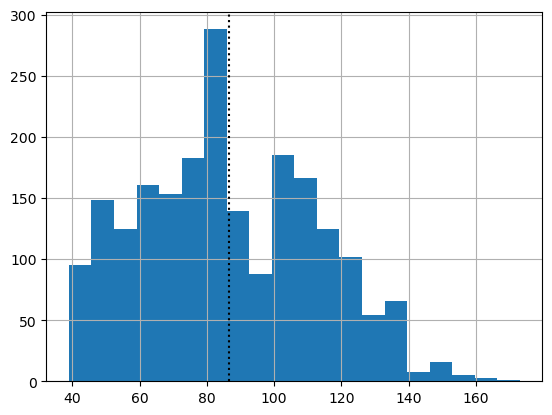

In [6]:
plt.axvline( x = obesity_data['Weight'].mean() ,
             linestyle = 'dotted',
             color = 'black')

obesity_data['Weight'].hist(bins = 20)

<Axes: >

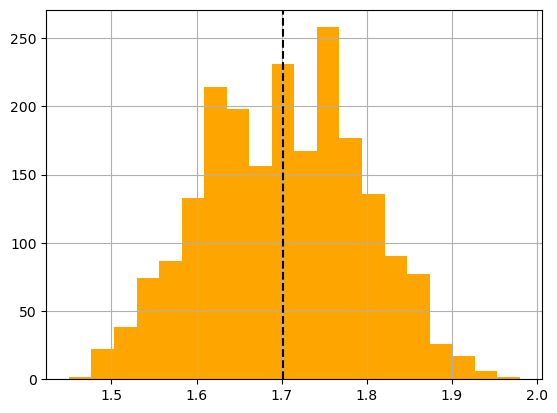

In [7]:
plt.axvline( x = obesity_data['Height'].mean() ,
             linestyle = '--',
             color = 'black')

obesity_data['Height'].hist(bins = 20,
                            color = 'orange')

<Axes: >

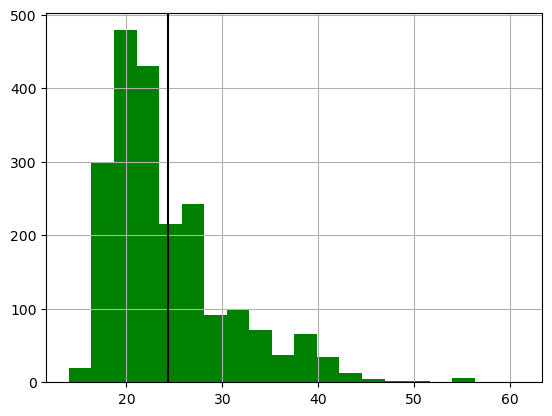

In [8]:
plt.axvline( x = obesity_data['Age'].mean() ,
             linestyle = '-',
             color = 'black')

obesity_data['Age'].hist(bins = 20,
                         color = 'Green')

#### FUNCTIONS

In [9]:
def cleaner(df, 
            unneeded_columns=None, 
            date_columns=None, 
            date_format = None , 
            to_category_columns=None, 
            to_cat_code_columns = None , 
            outlier_columns=None):

    """ 
    This function get pandas DataFrame and attributes like 'date_columns' and 'to_category_columns' to manipulate ,
    clean and prepare dataset for usage.
    
    """
    
    # Convert specified columns to datetime
    if date_columns:
        for date_column in date_columns:
            if date_column in df.columns:
                df[date_column] = pd.to_datetime(df[date_column], format = date_format ,errors='coerce')

    # Convert specified columns to category
    if to_category_columns:
        for category_column in to_category_columns:
            if category_column in df.columns:
                df[category_column] = df[category_column].astype('category')
                
        if to_cat_code_columns:
            for column in to_cat_code_columns:
                df[f'{column}_code'] = df[column].cat.codes

    # Handle outliers using the IQR method
    if outlier_columns:
        for outlier_column in outlier_columns:
            if outlier_column in df.columns:
                iqr = df[outlier_column].quantile(0.75) - df[outlier_column].quantile(0.25)
                lower_bound = df[outlier_column].quantile(0.25) - (1.5 * iqr)
                upper_bound = df[outlier_column].quantile(0.75) + (1.5 * iqr)
                df = df[(df[outlier_column] >= lower_bound) & (df[outlier_column] <= upper_bound)]

     # Drop unnecessary columns
    if unneeded_columns:
        df = df.drop(columns=unneeded_columns)  # Use 'errors="ignore"' to avoid errors if columns don't exist.

    # Rename columns
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.str.replace('(', '', regex=False)
    df.columns = df.columns.str.replace(')', '', regex=False)
    df.columns = df.columns.str.replace('-', '_', regex=False)
    df.columns = df.columns.str.replace('.', '', regex=False)
    df.columns = df.columns.str.replace('/', '', regex=False)
    df.columns = df.columns.str.replace('\\', '', regex=False)
    df.columns = df.columns.str.replace('%', '_percent', regex=False)
    
    return df

## CLEAN & PREPARE

In [10]:
obesity_data = cleaner(df = obesity_data, 
                       unneeded_columns=None, 
                       date_columns=None, 
                       date_format = None , 
                       to_category_columns=['Gender','CALC','FAVC',
                                            'SCC','SMOKE','family_history_with_overweight',
                                            'CAEC','MTRANS','NObeyesdad'], 
                       to_cat_code_columns = ['Gender','CALC','FAVC',
                                              'SCC','SMOKE','family_history_with_overweight',
                                              'CAEC','MTRANS','NObeyesdad'] , 
                       outlier_columns=None)

In [11]:
obesity_data.sample(5)

,age,gender,height,weight,calc,favc,fcvc,ncp,scc,smoke,...,nobeyesdad,gender_code,calc_code,favc_code,scc_code,smoke_code,family_history_with_overweight_code,caec_code,mtrans_code,nobeyesdad_code
435,19.00,Female,1.76,80.00,no,yes,2.00,1.00,no,no,...,Overweight_Level_I,0,3,1,0,0,1,2,3,5
1219,24.08,Male,1.73,97.91,no,yes,2.00,3.00,no,no,...,Obesity_Type_I,1,3,1,0,0,1,2,3,2
891,20.90,Female,1.71,75.00,Sometimes,yes,2.10,3.00,no,no,...,Overweight_Level_I,0,2,1,0,0,1,2,3,5
3,27.00,Male,1.80,87.00,Frequently,no,3.00,3.00,no,no,...,Overweight_Level_I,1,1,0,0,0,0,2,4,5
1816,24.27,Female,1.72,114.51,Sometimes,yes,3.00,3.00,no,no,...,Obesity_Type_III,0,2,1,0,0,1,2,3,4


In [12]:
category_columns = ['gender', 'calc', 'favc', 'scc', 'smoke', 
                    'family_history_with_overweight', 'caec', 'mtrans', 'nobeyesdad']

category_mappings = {col: dict(enumerate(obesity_data[col].cat.categories)) for col in category_columns}

# Reverse mapping (encoded value → category)
reverse_mappings = {col: {v: k for k, v in mapping.items()} for col, mapping in category_mappings.items()}


In [13]:
category_mappings

{'gender': {0: 'Female', 1: 'Male'},
 'calc': {0: 'Always', 1: 'Frequently', 2: 'Sometimes', 3: 'no'},
 'favc': {0: 'no', 1: 'yes'},
 'scc': {0: 'no', 1: 'yes'},
 'smoke': {0: 'no', 1: 'yes'},
 'family_history_with_overweight': {0: 'no', 1: 'yes'},
 'caec': {0: 'Always', 1: 'Frequently', 2: 'Sometimes', 3: 'no'},
 'mtrans': {0: 'Automobile',
  1: 'Bike',
  2: 'Motorbike',
  3: 'Public_Transportation',
  4: 'Walking'},
 'nobeyesdad': {0: 'Insufficient_Weight',
  1: 'Normal_Weight',
  2: 'Obesity_Type_I',
  3: 'Obesity_Type_II',
  4: 'Obesity_Type_III',
  5: 'Overweight_Level_I',
  6: 'Overweight_Level_II'}}

<Axes: >

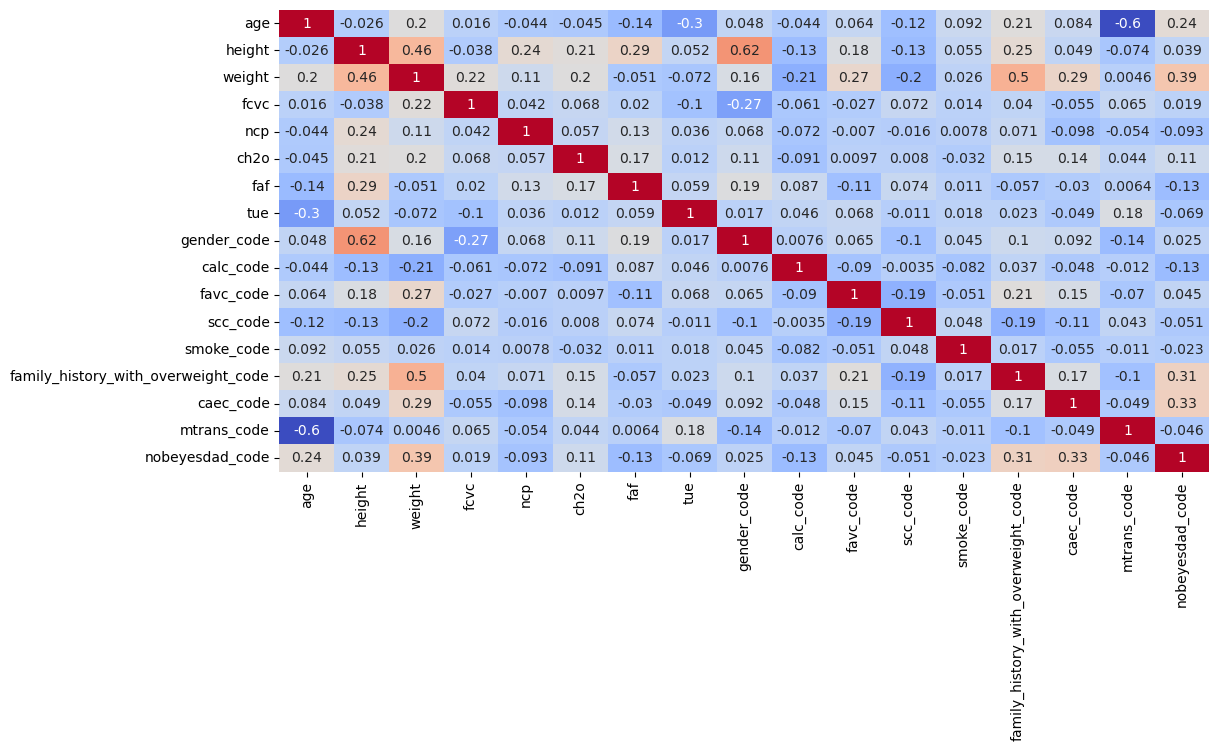

In [14]:
obesity_data_num = obesity_data.select_dtypes(include = ('number'))


plt.figure(figsize = (12,6))

sns.heatmap( data = obesity_data_num.corr() ,
             annot = True ,
             cmap = 'coolwarm',
             cbar = False )


#### PREPARE DATA FOR MODEL BUILDING

In [133]:
obesity_data_independent = obesity_data_num.drop(columns = ['nobeyesdad_code'] )

obesity_data_dependent = obesity_data_num['nobeyesdad_code']


#### SPLIT

In [18]:
pd.Series(obesity_data_dependent).value_counts()

nobeyesdad_code
2    351
4    324
3    297
5    290
6    290
1    287
0    272
Name: count, dtype: int64

In [134]:

obesity_data_independent_train , obesity_data_independent_test , obesity_data_dependent_train , obesity_data_dependent_test = train_test_split(
    obesity_data_independent ,
     obesity_data_dependent ,
    train_size = 0.8 ,
    stratify = obesity_data_dependent ,
    random_state = 42
)

obesity_data_independent_train ,obesity_data_independent_validation , obesity_data_dependent_train , obesity_data_dependent_validation = train_test_split(
    obesity_data_independent_train ,
     obesity_data_dependent_train ,
    train_size = 0.85 ,
    stratify = obesity_data_dependent_train ,
    random_state = 42
)

In [135]:
print(f'ARRAY SHAPES (TRAIN - TEST - VALIDATION) : {obesity_data_independent_train.shape , obesity_data_independent_test.shape , obesity_data_independent_validation.shape}')

ARRAY SHAPES (TRAIN - TEST - VALIDATION) : ((1434, 16), (423, 16), (254, 16))


## MODEL BUILD

#### HGB

In [138]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [142]:
obesity_hgb_param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size
    'max_iter': [100, 300, 500],  # Number of boosting iterations
    'max_depth': [None, 3, 5, 7],  # Maximum tree depth
    'min_samples_leaf': [10, 20, 50],  # Minimum samples per leaf
    'l2_regularization': [0, 0.1, 1],  # L2 regularization
    'max_bins': [128, 255],  # Valid range: 2 to 255
}

In [143]:
obesity_hgb_random_search_cv = RandomizedSearchCV( estimator = HistGradientBoostingClassifier() ,
                                                   param_distributions = obesity_hgb_param_distributions,
                                                   scoring = 'f1_macro',
                                                   n_iter = 25,
                                                   cv = 10 )

In [144]:
obesity_hgb_random_search_cv.fit(obesity_data_independent_train,
                                 obesity_data_dependent_train)

RandomizedSearchCV(cv=10, estimator=HistGradientBoostingClassifier(), n_iter=25,
                   param_distributions={'l2_regularization': [0, 0.1, 1],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_bins': [128, 255],
                                        'max_depth': [None, 3, 5, 7],
                                        'max_iter': [100, 300, 500],
                                        'min_samples_leaf': [10, 20, 50]},
                   scoring='f1_macro')

In [145]:
obesity_hgb_random_search_cv.best_params_

{'min_samples_leaf': 20,
 'max_iter': 500,
 'max_depth': 3,
 'max_bins': 128,
 'learning_rate': 0.1,
 'l2_regularization': 0}

In [146]:
obesity_hgb_random_search_cv.best_score_

0.9763197163007703

In [148]:
obesity_hgb_random_search_cv_validation_predictions = obesity_hgb_random_search_cv.predict( obesity_data_independent_validation )

obesity_hgb_random_search_cv_validation_predictions_report = metrics.classification_report( obesity_data_dependent_validation ,
                                                                                            obesity_hgb_random_search_cv_validation_predictions)



print(obesity_hgb_random_search_cv_validation_predictions_report)


              precision    recall  f1-score   support

           0       0.94      1.00      0.97        33
           1       1.00      0.88      0.94        34
           2       1.00      0.98      0.99        42
           3       1.00      1.00      1.00        36
           4       1.00      1.00      1.00        39
           5       0.92      0.97      0.94        35
           6       0.94      0.97      0.96        35

    accuracy                           0.97       254
   macro avg       0.97      0.97      0.97       254
weighted avg       0.97      0.97      0.97       254



#### ExtraTrees

In [153]:
from sklearn.ensemble import ExtraTreesClassifier

obesity_extra_trees_param_distributions = {
    'n_estimators': [100, 300, 500],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Min samples to split
    'min_samples_leaf': [1, 2, 5, 10],  # Min samples per leaf
    'max_features': ['sqrt', 'log2', None],  # Feature selection per split
    'bootstrap': [False, True]  # Bootstrapping
}

In [157]:
obesity_extra_trees_random_search_cv = RandomizedSearchCV( estimator = ExtraTreesClassifier() ,
                                                           param_distributions = obesity_extra_trees_param_distributions,
                                                           scoring = 'f1_macro',
                                                           n_iter = 25,
                                                           cv = 10 )

In [158]:
obesity_extra_trees_random_search_cv.fit(obesity_data_independent_train,
                                         obesity_data_dependent_train)

RandomizedSearchCV(cv=10, estimator=ExtraTreesClassifier(), n_iter=25,
                   param_distributions={'bootstrap': [False, True],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 300, 500]},
                   scoring='f1_macro')

In [159]:
obesity_extra_trees_random_search_cv.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': None,
 'bootstrap': True}

In [160]:
obesity_extra_trees_random_search_cv.best_score_

0.9617751820388637

In [161]:
obesity_extra_trees_random_search_cv_validation_predictions = obesity_extra_trees_random_search_cv.predict( obesity_data_independent_validation )

obesity_extra_trees_random_search_cv_validation_predictions_report = metrics.classification_report( obesity_data_dependent_validation ,
                                                                                                    obesity_extra_trees_random_search_cv_validation_predictions)



print(obesity_extra_trees_random_search_cv_validation_predictions_report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        33
           1       0.91      0.85      0.88        34
           2       0.98      0.98      0.98        42
           3       1.00      0.97      0.99        36
           4       1.00      1.00      1.00        39
           5       0.90      1.00      0.95        35
           6       0.97      0.94      0.96        35

    accuracy                           0.96       254
   macro avg       0.96      0.96      0.96       254
weighted avg       0.96      0.96      0.96       254



#### KNeighbors

In [168]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [170]:
obesity_kneighbors_pipeline = Pipeline( [
    ('Scaler',StandardScaler()),
    ('PCA',PCA(n_components = 12)),
    ('KNN',KNeighborsClassifier())
] )

In [171]:
obesity_kneighbors_pipeline.fit(obesity_data_independent_train,
                                obesity_data_dependent_train)

Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA(n_components=12)),
                ('KNN', KNeighborsClassifier())])

In [172]:
obesity_kneighbors_pipeline_predictions = obesity_kneighbors_pipeline.predict( obesity_data_independent_validation )

obesity_kneighbors_pipeline_predictions_report = metrics.classification_report( obesity_data_dependent_validation ,
                                                                                obesity_kneighbors_pipeline_predictions)



print(obesity_kneighbors_pipeline_predictions_report)

              precision    recall  f1-score   support

           0       0.61      0.82      0.70        33
           1       0.62      0.38      0.47        34
           2       0.78      0.86      0.82        42
           3       0.90      0.97      0.93        36
           4       1.00      0.97      0.99        39
           5       0.76      0.74      0.75        35
           6       0.78      0.71      0.75        35

    accuracy                           0.79       254
   macro avg       0.78      0.78      0.77       254
weighted avg       0.79      0.79      0.78       254



#### Stacking

In [164]:
from sklearn.ensemble import StackingClassifier


In [182]:

obesity_base_learners = [
    ('HGB', HistGradientBoostingClassifier(
        min_samples_leaf=20,
        max_iter=500,
        max_depth=3,
        max_bins=128,
        learning_rate=0.1,
        l2_regularization=0
    )),

    ('ExtraTrees', ExtraTreesClassifier(
        n_estimators=300,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=None,
        max_depth=None,
        bootstrap=True
    )),

    ('PipelineKNN', Pipeline([
        ('Scaler', StandardScaler()),
        ('PCA', PCA(n_components=12)),
        ('KNN', KNeighborsClassifier())
    ]))
]

In [183]:
obesity_stacking = StackingClassifier( estimators = obesity_base_learners )

obesity_stacking.fit(obesity_data_independent_train,
                     obesity_data_dependent_train)

StackingClassifier(estimators=[('HGB',
                                HistGradientBoostingClassifier(l2_regularization=0,
                                                               max_bins=128,
                                                               max_depth=3,
                                                               max_iter=500)),
                               ('ExtraTrees',
                                ExtraTreesClassifier(bootstrap=True,
                                                     max_features=None,
                                                     n_estimators=300)),
                               ('PipelineKNN',
                                Pipeline(steps=[('Scaler', StandardScaler()),
                                                ('PCA', PCA(n_components=12)),
                                                ('KNN',
                                                 KNeighborsClassifier())]))])

In [184]:
obesity_stacking_validation_predictions = obesity_stacking.predict( obesity_data_independent_validation )

obesity_stacking_validation_predictions_report = metrics.classification_report( obesity_data_dependent_validation ,
                                                                                obesity_stacking_validation_predictions)



print(obesity_stacking_validation_predictions_report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       1.00      0.91      0.95        34
           2       1.00      0.98      0.99        42
           3       1.00      1.00      1.00        36
           4       1.00      1.00      1.00        39
           5       0.92      0.97      0.94        35
           6       0.94      0.97      0.96        35

    accuracy                           0.98       254
   macro avg       0.98      0.98      0.98       254
weighted avg       0.98      0.98      0.98       254



### TEST EVALUATION

#### HGB

In [186]:
obesity_hgb_random_search_cv_test_predictions = obesity_hgb_random_search_cv.predict( obesity_data_independent_test )

obesity_hgb_random_search_cv_test_predictions_report = metrics.classification_report( obesity_data_dependent_test ,
                                                                                      obesity_hgb_random_search_cv_test_predictions)



print(obesity_hgb_random_search_cv_test_predictions_report)


              precision    recall  f1-score   support

           0       0.96      0.93      0.94        54
           1       0.86      0.95      0.90        58
           2       0.99      0.99      0.99        70
           3       0.98      0.98      0.98        60
           4       1.00      0.98      0.99        65
           5       0.96      0.91      0.94        58
           6       1.00      1.00      1.00        58

    accuracy                           0.96       423
   macro avg       0.96      0.96      0.96       423
weighted avg       0.97      0.96      0.96       423



#### ExtraTrees

In [187]:
obesity_extra_trees_random_search_cv_test_predictions = obesity_extra_trees_random_search_cv.predict( obesity_data_independent_test )

obesity_extra_trees_random_search_cv_test_predictions_report = metrics.classification_report( obesity_data_dependent_test ,
                                                                                              obesity_extra_trees_random_search_cv_test_predictions )



print(obesity_extra_trees_random_search_cv_test_predictions_report)


              precision    recall  f1-score   support

           0       0.98      0.94      0.96        54
           1       0.88      0.91      0.90        58
           2       0.99      0.99      0.99        70
           3       0.98      0.98      0.98        60
           4       1.00      0.98      0.99        65
           5       0.93      0.93      0.93        58
           6       0.98      1.00      0.99        58

    accuracy                           0.96       423
   macro avg       0.96      0.96      0.96       423
weighted avg       0.97      0.96      0.96       423



#### KNN

In [188]:
obesity_kneighbors_pipeline_test_predictions = obesity_kneighbors_pipeline.predict( obesity_data_independent_test )

obesity_kneighbors_pipeline_test_predictions_report = metrics.classification_report( obesity_data_dependent_test ,
                                                                                     obesity_kneighbors_pipeline_test_predictions )



print(obesity_kneighbors_pipeline_test_predictions_report)

              precision    recall  f1-score   support

           0       0.72      0.94      0.82        54
           1       0.65      0.45      0.53        58
           2       0.71      0.86      0.78        70
           3       0.79      0.88      0.83        60
           4       0.98      0.98      0.98        65
           5       0.73      0.57      0.64        58
           6       0.76      0.67      0.72        58

    accuracy                           0.77       423
   macro avg       0.77      0.77      0.76       423
weighted avg       0.77      0.77      0.76       423



#### Stacking

In [189]:
obesity_stacking_test_predictions = obesity_stacking.predict( obesity_data_independent_test )

obesity_stacking_test_predictions_report = metrics.classification_report( obesity_data_dependent_test ,
                                                                           obesity_stacking_test_predictions )



print(obesity_stacking_test_predictions_report)

              precision    recall  f1-score   support

           0       0.98      0.91      0.94        54
           1       0.85      0.97      0.90        58
           2       0.99      0.99      0.99        70
           3       0.98      0.98      0.98        60
           4       1.00      0.98      0.99        65
           5       0.96      0.91      0.94        58
           6       1.00      1.00      1.00        58

    accuracy                           0.96       423
   macro avg       0.97      0.96      0.96       423
weighted avg       0.97      0.96      0.96       423



## SAVE

In [193]:
from joblib import dump , load

In [192]:
dump(obesity_stacking,
     "obesity_stacking.joblib")

['obesity_stacking.joblib']

In [194]:
#### TETS LOAD

obesity_stacking = load(r"C:\Users\User\Desktop\obesity\models\obesity_stacking.joblib")


In [195]:
obesity_stacking

StackingClassifier(estimators=[('HGB',
                                HistGradientBoostingClassifier(l2_regularization=0,
                                                               max_bins=128,
                                                               max_depth=3,
                                                               max_iter=500)),
                               ('ExtraTrees',
                                ExtraTreesClassifier(bootstrap=True,
                                                     max_features=None,
                                                     n_estimators=300)),
                               ('PipelineKNN',
                                Pipeline(steps=[('Scaler', StandardScaler()),
                                                ('PCA', PCA(n_components=12)),
                                                ('KNN',
                                                 KNeighborsClassifier())]))])